# Recurrent Neural Networks

In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


## Load the data

First you need to download the file `airline-passengers.csv` and upload it within google colab. On the very left side of the screen, there are 3 symbols. The bottom one is files. Click that and then upload the data to be able to access it within google colab. 

In [2]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataframe.head

<bound method NDFrame.head of      Passengers
0           112
1           118
2           132
3           129
4           121
..          ...
139         606
140         508
141         461
142         390
143         432

[144 rows x 1 columns]>

`MinMaxScaler` is a **class** that allows us to scale the data between a certain range.

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))

This means that `scaler` is now an instance of the class `MinMaxScaler`, and we can call all functions within `MinMaxScaler` by using `scaler.function_name`. Lets use this to send the data to the range [0,1]

In [4]:
dataset = scaler.fit_transform(dataframe)
dataset

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984556],
       [0.08494208],
       [0.08494208],
       [0.06177606],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123552],
       [0.04247104],
       [0.07142857],
       [0.05984556],
       [0.04054054],
       [0.08687259],
       [0.12741313],
       [0.12741313],
       [0.1042471 ],
       [0.05598456],
       [0.01930502],
       [0.06949807],
       [0.07915058],
       [0.08880309],
       [0.14285714],
       [0.11389961],
       [0.13127413],
       [0.14285714],
       [0.18339768],
       [0.18339768],
       [0.15444015],
       [0.11196911],
       [0.08108108],
       [0.11969112],
       [0.12934363],
       [0.14671815],
       [0.17181467],
       [0.14864865],
       [0.15250965],
       [0.22007722],
       [0.24324324],
       [0.26640927],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

Now we will split the data into 67% training and 33% testing.

In [5]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

We want to convert the data so there are two columns: one at time step $t$, one at timestep $t+1$. We will create a function to do this for us.

You can think of this similar to how we have used supervision labels in the past, the first column is the input and the second column is what we are trying to predict.

In [16]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_diff=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_diff-1):
        a = dataset[i:(i+time_diff), 0] #this is only really useful with time_diff > 1. For time_diff=1 we can just use i
        dataX.append(a)
        dataY.append(dataset[i + time_diff, 0])
        
    return numpy.array(dataX), numpy.array(dataY)

Now call the function we have just created.

In [7]:
time_diff = 1
trainX, trainY = create_dataset(train, time_diff)
testX, testY = create_dataset(test, time_diff)

In [8]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
[trainX[:5], trainY[:5]]

[array([[[0.01544402]],
 
        [[0.02702703]],
 
        [[0.05405405]],
 
        [[0.04826255]],
 
        [[0.03281853]]]),
 array([0.02702703, 0.05405405, 0.04826255, 0.03281853, 0.05984556])]

## Baseline Implementation
We will use a sequential model similar to the ones we've used in the past. The difference is that we will add an LSTM layer. This makes the network a *Recurrent Neural Network*

### Recurrent Neural Networks
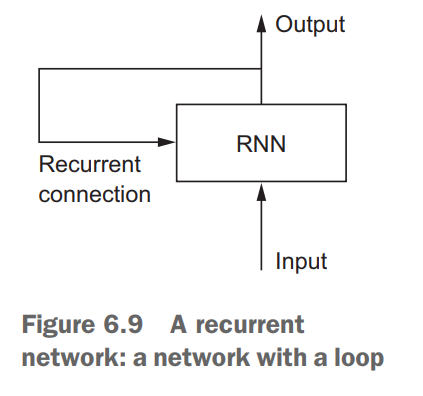

In [9]:
model = Sequential()
model.add(LSTM(10, input_shape=(1, time_diff)))
model.add(Dense(6, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam') #Note that the loss is now mean squared error
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0409
Epoch 2/100
 - 0s - loss: 0.0179
Epoch 3/100
 - 0s - loss: 0.0164
Epoch 4/100
 - 0s - loss: 0.0148
Epoch 5/100
 - 0s - loss: 0.0127
Epoch 6/100
 - 0s - loss: 0.0107
Epoch 7/100
 - 0s - loss: 0.0081
Epoch 8/100
 - 0s - loss: 0.0056
Epoch 9/100
 - 0s - loss: 0.0041
Epoch 10/100
 - 0s - loss: 0.0030
Epoch 11/100
 - 0s - loss: 0.0022
Epoch 12/100
 - 0s - loss: 0.0021
Epoch 13/100
 - 0s - loss: 0.0021
Epoch 14/100
 - 0s - loss: 0.0021
Epoch 15/100
 - 0s - loss: 0.0021
Epoch 16/100
 - 0s - loss: 0.0021
Epoch 17/100
 - 0s - loss: 0.0020
Epoch 18/100
 - 0s - loss: 0.0020
Epoch 19/100
 - 0s - loss: 0.0020
Epoch 20/100
 - 0s - loss: 0.0019
Epoch 21/100
 - 0s - loss: 0.0021
Epoch 22/100
 - 0s - loss: 0.0021
Epoch 23/100
 - 0s - loss: 0.0022
Epoch 24/100
 - 0s - loss: 0.0020
Epoch 25/100
 - 0s - loss: 0.0021
Epoch 26/100
 - 0s - loss: 0.0021
Epoch 27/100
 - 0s - loss: 0.0020
Epoch 28/100
 - 0s - loss: 0.0020
Epoch 29/100
 - 0s - loss: 0.0020
Epoch 30/100
 - 0s - lo

In [10]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

### Unscaling the data
During the pre-processing stage, we scaled the data down to be between 0 and 1. Now to view the results, we need to scale it back up to its initial size. We can call the function `inverse_transform` within `scaler` to do this. 

In [11]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [12]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.06 RMSE
Test Score: 49.95 RMSE


### Plotting
The remaining cells set up our predictions so that we can plot them onto the original graph.

In [13]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[time_diff:len(trainPredict)+time_diff, :] = trainPredict

In [14]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(time_diff*2)+1:len(dataset)-1, :] = testPredict

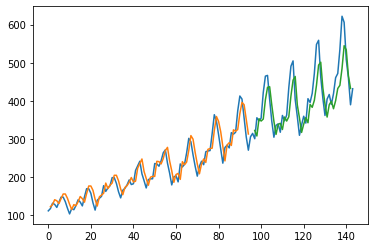

In [15]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

We see that the green line (representing our test predictions) is very close to the actual data.